[*********************100%%**********************]  1 of 1 completed


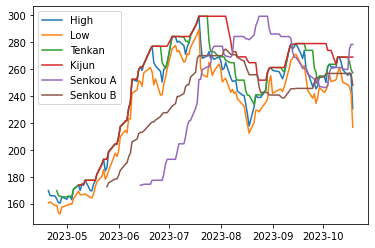

In [93]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download stock data
ticker = "TSLA" 
data = yf.download(ticker, period="6mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max() 
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)  
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Plot Ichimoku cloud chart
plt.plot(data['High'], label='High')
plt.plot(data['Low'], label='Low')
plt.plot(data['Tenkan'], label='Tenkan')
plt.plot(data['Kijun'], label='Kijun')
plt.plot(data['Senkou A'], label='Senkou A')
plt.plot(data['Senkou B'], label='Senkou B')
plt.legend()
plt.show()

In [128]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Download stock data
ticker = "TSLA" 
data = yf.download(ticker, period="8mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max() 
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)  
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

total_data_points = data.shape[0]
print("Total data points:", total_data_points)

# Print the count of NAs before filling
na_count_before = data.isna().sum()
print("NAs count before filling:")
print(na_count_before)

# Normalize components to 0-255 range
# Fill missing values with a constant (0 in this case)
tenkan_norm = np.round((data['Tenkan'].fillna(0) - data['Tenkan'].min()) /
                       (data['Tenkan'].max() - data['Tenkan'].min()) * 255).astype(int)

kijun_norm = np.round((data['Kijun'].fillna(0) - data['Kijun'].min()) /
                      (data['Kijun'].max() - data['Kijun'].min()) * 255).astype(int)

senkouA_norm = np.round((data['Senkou A'].fillna(0) - data['Senkou A'].min()) /
                       (data['Senkou A'].max() - data['Senkou A'].min()) * 255).astype(int)

senkouB_norm = np.round((data['Senkou B'].fillna(0) - data['Senkou B'].min()) /
                       (data['Senkou B'].max() - data['Senkou B'].min()) * 255).astype(int)


# Construct image samples 
X = []
y = []

# Look at historical windows
input_window = 20
output_window = 5  

for i in range(input_window, len(data)-output_window):
  x_i = np.dstack([tenkan_norm.values[i-input_window:i],
                   kijun_norm.values[i-input_window:i],
                   senkouA_norm.values[i-input_window:i], 
                   senkouB_norm.values[i-input_window:i]])
  X.append(x_i)
  y.append(data['Close'].values[i+output_window] > data['Close'].values[i])

X = np.array(X)  
X = X.reshape(-1, input_window, 4, 1)  # 4 channels
y = np.array(y)

# Print the number of images used
num_images = len(X)
print("Number of images used:", num_images)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and validation data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Define the CNN model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(20, 4, 1)))
model.add(Dropout(0.5))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Print the CNN architecture summary
model.summary()

# Compile and train the model
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)

[*********************100%%**********************]  1 of 1 completed
Total data points: 168
NAs count before filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        8
Kijun        25
Senkou A     77
Senkou B     51
dtype: int64
Number of images used: 143
X_train shape: (114, 20, 4, 1)
y_train shape: (114,)
X_val shape: (29, 20, 4, 1)
y_val shape: (29,)
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 18, 2, 16)         160       
                                                                 
 dropout_9 (Dropout)         (None, 18, 2, 16)         0         
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 9, 1, 16)         0         
 g2D)                                                            
                               

1/1 [==============================] - 0s 13ms/step


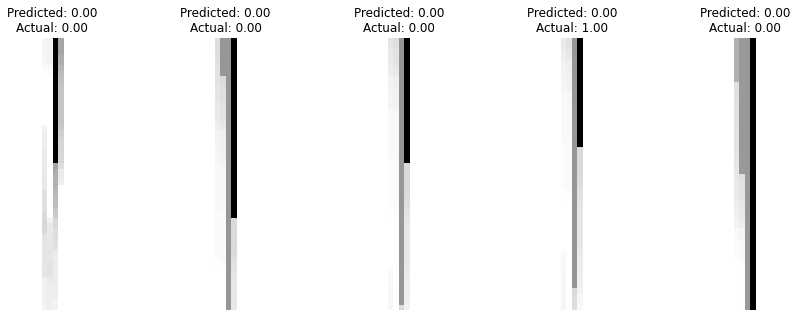

1/1 [==============================] - 0s 14ms/step - loss: 0.4667
Mean Squared Error on Validation Set: 0.4667


In [43]:
# Print some of the images
import random
import matplotlib.pyplot as plt

# Randomly select and display a few images and their corresponding predictions
num_samples = 5
selected_indices = random.sample(range(X_val.shape[0]), num_samples)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(selected_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_val[idx, :, :, 0], cmap='gray')
    plt.title(f"Predicted: {model.predict(X_val[idx:idx+1])[0][0]:.2f}\nActual: {y_val[idx]:.2f}")
    plt.axis('off')
plt.show()

# Interpretation of the MSE result
mse = model.evaluate(X_val, y_val)
print(f"Mean Squared Error on Validation Set: {mse:.4f}")


In [51]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Download stock data
ticker = "TSLA" 
data = yf.download(ticker, period="6mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max() 
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)  
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

total_data_points = data.shape[0]
print("Total data points:", total_data_points)

# Print the count of NAs before filling
na_count_before = data.isna().sum()
print("NAs count before filling:")
print(na_count_before)

# Normalize components to 0-255 range
# Fill missing values with a constant (0 in this case)
tenkan_norm = np.round((data['Tenkan'].fillna(0) - data['Tenkan'].min()) /
                       (data['Tenkan'].max() - data['Tenkan'].min()) * 255).astype(int)

kijun_norm = np.round((data['Kijun'].fillna(0) - data['Kijun'].min()) /
                      (data['Kijun'].max() - data['Kijun'].min()) * 255).astype(int)

senkouA_norm = np.round((data['Senkou A'].fillna(0) - data['Senkou A'].min()) /
                       (data['Senkou A'].max() - data['Senkou A'].min()) * 255).astype(int)

senkouB_norm = np.round((data['Senkou B'].fillna(0) - data['Senkou B'].min()) /
                       (data['Senkou B'].max() - data['Senkou B'].min()) * 255).astype(int)


# Construct image samples 
X = []
y = []

# Look at historical windows
input_window = 50
output_window = 5  

for i in range(input_window, len(data)-output_window):
    if not any(data['Tenkan'].isna().iloc[i-input_window:i]) and \
       not any(data['Kijun'].isna().iloc[i-input_window:i]) and \
       not any(data['Senkou A'].isna().iloc[i-input_window:i]) and \
       not any(data['Senkou B'].isna().iloc[i-input_window:i]):

        x_i = np.dstack([tenkan_norm.values[i-input_window:i],
                        kijun_norm.values[i-input_window:i],
                        senkouA_norm.values[i-input_window:i], 
                        senkouB_norm.values[i-input_window:i]])
        X.append(x_i)
        y.append(data['Close'].values[i+output_window] > data['Close'].values[i])

X = np.array(X)  
X = X.reshape(-1, input_window, 4, 1)  # 4 channels
y = np.array(y)

# Print the number of images used
num_images = len(X)
print("Number of images used:", num_images)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and validation data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Define the CNN model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(50, 4, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Print the CNN architecture summary
model.summary()

# Compile and train the model
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)


[*********************100%%**********************]  1 of 1 completed
Total data points: 127
NAs count before filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        8
Kijun        25
Senkou A     77
Senkou B     51
dtype: int64
Number of images used: 0


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [50]:
import yfinance as yf
import pandas as pd

# Download stock data
ticker = "TSLA" 
data = yf.download(ticker, period="6mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

total_data_points = data.shape[0]
print("Total data points:", total_data_points)
# Interpolate NAs in the data
data.interpolate(method='linear', inplace=True)

# Calculate Tenkan-sen
data['Tenkan'] = data['High'].rolling(window=tenkan_period).max() 

# Calculate Kijun-sen
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

# Calculate Senkou Span A
data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)

# Calculate Senkou Span B
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Check the NAs count after filling
na_count_after = data.isna().sum()
print("NAs count after filling:")
print(na_count_after)


[*********************100%%**********************]  1 of 1 completed
Total data points: 127
NAs count after filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        8
Kijun        25
Senkou A     77
Senkou B     51
dtype: int64


In [124]:
import numpy as np
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define a list of stock tickers
tickers = ["TSLA", "AAPL", "GOOG","COST","BAC","AMD"]

# Create an empty list to store dataframes for each stock
data_frames = []

# Download data for each stock and store it in the list
for ticker in tickers:
    data = yf.download(ticker, period="8mo", interval="1d")
    data['Ticker'] = ticker  # Ad,"COST","BAC","AMD"d a Ticker column to identify the stock
    data_frames.append(data)

# Concatenate data for all stocks along the time axis
data = pd.concat(data_frames)

# Calculate Ichimoku components for each stock
tenkan_period = 4
kijun_period = 13
senkou_period = 26

for ticker in tickers:
    data[f'{ticker}_Tenkan'] = data[data['Ticker'] == ticker]['High'].rolling(window=tenkan_period).max()
    data[f'{ticker}_Kijun'] = data[data['Ticker'] == ticker]['High'].rolling(window=kijun_period).max()
    data[f'{ticker}_Senkou A'] = (
        (data[f'{ticker}_Tenkan'] + data[f'{ticker}_Kijun']) / 2
    ).shift(senkou_period)
    data[f'{ticker}_Senkou B'] = (
        (data[data['Ticker'] == ticker]['High'].rolling(window=senkou_period).max() + data[data['Ticker'] == ticker]['Low'].rolling(window=senkou_period).min())
        / 2
    )

# Total data points
total_data_points = data.shape[0]
print("Total data points:", total_data_points)
data.dropna(inplace=True)
data.interpolate(method='linear', inplace=True)


# Normalize components
for ticker in tickers:
    data[f'{ticker}_Tenkan'] = np.round(
        (data[f'{ticker}_Tenkan'] - data[f'{ticker}_Tenkan'].min())
        / (data[f'{ticker}_Tenkan'].max() - data[f'{ticker}_Tenkan'].min())
        * 255
    ).astype(int)
    data[f'{ticker}_Kijun'] = np.round(
        (data[f'{ticker}_Kijun'] - data[f'{ticker}_Kijun'].min())
        / (data[f'{ticker}_Kijun'].max() - data[f'{ticker}_Kijun'].min())
        * 255
    ).astype(int)
    data[f'{ticker}_Senkou A'] = np.round(
        (data[f'{ticker}_Senkou A'] - data[f'{ticker}_Senkou A'].min())
        / (data[f'{ticker}_Senkou A'].max() - data[f'{ticker}_Senkou A'].min())
        * 255
    ).astype(int)
    data[f'{ticker}_Senkou B'] = np.round(
        (data[f'{ticker}_Senkou B'] - data[f'{ticker}_Senkou B'].min())
        / (data[f'{ticker}_Senkou B'].max() - data[f'{ticker}_Senkou B'].min())
        * 255
    ).astype(int)

# Construct image samples
X = []
y = []

input_window = 20
output_window = 5

# Determine the minimum number of data points for all stocks
min_data_points = data.groupby('Ticker').size().min()

for i in range(input_window, min_data_points - output_window):
    x_i = np.dstack(
        [
            data[data['Ticker'] == ticker][f'{ticker}_Tenkan'].values[i - input_window:i],
            data[data['Ticker'] == ticker][f'{ticker}_Kijun'].values[i - input_window:i],
            data[data['Ticker'] == ticker][f'{ticker}_Senkou A'].values[i - input_window:i],
            data[data['Ticker'] == ticker][f'{ticker}_Senkou B'].values[i - input_window:i],
        ]
    )
    X.append(x_i)
    y.append(
        data[data['Ticker'] == ticker]['Close'].values[i + output_window]
        > data[data['Ticker'] == ticker]['Close'].values[i]
    )

X = np.array(X)
X = X.reshape(-1, input_window, 4, 1)
y = np.array(y)

# Print the number of images used
num_images = len(X)
print("Number of images used:", num_images)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and validation data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Define the CNN model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(20, 4, 1)))
model.add(Dropout(0.5))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.add(Dropout(0.5))
# Print the CNN architecture summary
model.summary()

# Compile and train the model
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Total data points: 1008


C:\Users\beaud\AppData\Local\Temp\ipykernel_928\1135569292.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', inplace=True)


Number of images used: 105
X_train shape: (84, 20, 4, 1)
y_train shape: (84,)
X_val shape: (21, 20, 4, 1)
y_val shape: (21,)
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 18, 2, 16)         160       
                                                                 
 dropout_3 (Dropout)         (None, 18, 2, 16)         0         
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 9, 1, 16)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 9, 1, 16)          0         
                                                                 
 flatten_56 (Flatten)        (None, 144)               0         
                                                            

Epoch 1/150
9/9 [==============================] - 0s 7ms/step - loss: 0.2435 - accuracy: 0.8856 - val_loss: 0.9504 - val_accuracy: 0.7647
Epoch 2/150
9/9 [==============================] - 0s 4ms/step - loss: 0.2841 - accuracy: 0.8708 - val_loss: 0.8791 - val_accuracy: 0.7059
Epoch 3/150
9/9 [==============================] - 0s 4ms/step - loss: 0.1754 - accuracy: 0.9410 - val_loss: 0.7342 - val_accuracy: 0.7500
Epoch 4/150
9/9 [==============================] - 0s 4ms/step - loss: 0.1960 - accuracy: 0.9114 - val_loss: 0.8232 - val_accuracy: 0.7353
Epoch 5/150
9/9 [==============================] - 0s 4ms/step - loss: 0.1502 - accuracy: 0.9483 - val_loss: 0.8501 - val_accuracy: 0.7500
Epoch 6/150
9/9 [==============================] - 0s 4ms/step - loss: 0.2023 - accuracy: 0.9004 - val_loss: 0.9179 - val_accuracy: 0.7500
Epoch 7/150
9/9 [==============================] - 0s 4ms/step - loss: 0.1722 - accuracy: 0.9410 - val_loss: 0.8235 - val_accuracy: 0.7353
Epoch 8/150
9/9 [==========

9/9 [==============================] - 0s 4ms/step - loss: 0.0443 - accuracy: 0.9779 - val_loss: 0.7599 - val_accuracy: 0.8235
Epoch 118/150
9/9 [==============================] - 0s 4ms/step - loss: 0.0442 - accuracy: 0.9852 - val_loss: 0.7555 - val_accuracy: 0.8235
Epoch 119/150
9/9 [==============================] - 0s 4ms/step - loss: 0.0732 - accuracy: 0.9742 - val_loss: 0.8290 - val_accuracy: 0.8529
Epoch 120/150
9/9 [==============================] - 0s 4ms/step - loss: 0.0543 - accuracy: 0.9779 - val_loss: 0.7892 - val_accuracy: 0.8382
Epoch 121/150
9/9 [==============================] - 0s 4ms/step - loss: 0.0416 - accuracy: 0.9926 - val_loss: 0.7889 - val_accuracy: 0.8235
Epoch 122/150
9/9 [==============================] - 0s 4ms/step - loss: 0.0341 - accuracy: 0.9889 - val_loss: 1.0378 - val_accuracy: 0.7353
Epoch 123/150
9/9 [==============================] - 0s 4ms/step - loss: 0.0409 - accuracy: 0.9963 - val_loss: 0.7610 - val_accuracy: 0.8235
Epoch 124/150
9/9 [========

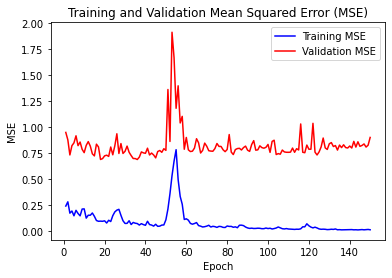

In [88]:
import matplotlib.pyplot as plt

# Assuming you have trained your model and stored the training history
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val))

# Access the MSE values from the history
train_mse = history.history['loss']
val_mse = history.history['val_loss']

# Plot both training and validation MSE
plt.plot(range(1, len(train_mse) + 1), train_mse, label='Training MSE', color='blue')
plt.plot(range(1, len(val_mse) + 1), val_mse, label='Validation MSE', color='red')
plt.title('Training and Validation Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [9]:
#train model for decisions
import numpy as np
import pandas as pd
import yfinance as yf  # Import yfinance library
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Download stock data
ticker = "TSLA" 
data = yf.download(ticker, period="8mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max() 
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)  
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate additional indicators
ma_period = 20
data['MA'] = data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 14
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Define a function to normalize and fill non-finite values
def normalize_and_fill(column):
    min_val = column.min()
    max_val = column.max()
    column = ((column - min_val) / (max_val - min_val)) * 255
    return column.fillna(0).astype(int)

data['Tenkan'] = normalize_and_fill(data['Tenkan'])
data['Kijun'] = normalize_and_fill(data['Kijun'])
data['Senkou A'] = normalize_and_fill(data['Senkou A'])
data['Senkou B'] = normalize_and_fill(data['Senkou B'])
data['MA'] = normalize_and_fill(data['MA'])
data['RSI'] = normalize_and_fill(data['RSI'])


# Construct image samples
X = []
y = []
input_window = 50
output_window = 5
for i in range(input_window, len(data) - output_window):
    x_i = np.dstack([
        data['Tenkan'].values[i - input_window:i],
        data['Kijun'].values[i - input_window:i],
        data['Senkou A'].values[i - input_window:i],
        data['Senkou B'].values[i - input_window:i],
        data['MA'].values[i - input_window:i],
        data['RSI'].values[i - input_window:i]
    ])

    X.append(x_i)

    y.append(data['Close'].values[i + output_window] > data['Close'].values[i])

X = np.array(X)
X = X.reshape(-1, input_window, 6, 1)
# Convert y to a NumPy array
y = np.array(y)

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) 

# Define model
input_shape = (input_window, 6, 1)  # Adjust the input shape to match the data
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile and train
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)

[*********************100%%**********************]  1 of 1 completed
Epoch 1/50
3/3 [==============================] - 0s 3ms/step - loss: 10.7942 - accuracy: 0.5055
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 10.3106 - accuracy: 0.5055
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 3.9059 - accuracy: 0.5714
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 6.1649 - accuracy: 0.4945
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 2.8053 - accuracy: 0.6044
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 4.2252 - accuracy: 0.5714
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 2.0970 - accuracy: 0.6923
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 2.0870 - accuracy: 0.6484
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 1.2042 - accuracy: 0.7253
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - 

In [100]:
import yfinance as yf
import numpy as np
import pandas as pd

# Download the latest data for TSLA
ticker = "TSLA"
data = yf.download(ticker, period="1mo", interval="1m")  # Adjust the period and interval as needed

# Calculate Ichimoku components (Tenkan, Kijun, Senkou A, Senkou B) and additional indicators (MA and RSI)
tenkan_period = 9
kijun_period = 26
senkou_period = 52
ma_period = 20
rsi_period = 14

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max()
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Average (MA) for the data
data['MA'] = data['Close'].rolling(ma_period).mean()

# Normalize the data
def normalize_column(column):
    min_val = column.min()
    max_val = column.max()
    column = ((column - min_val) / (max_val - min_val)) * 255
    return column.fillna(0).astype(int)

data['Tenkan'] = normalize_column(data['Tenkan'])
data['Kijun'] = normalize_column(data['Kijun'])
data['Senkou A'] = normalize_column(data['Senkou A'])
data['Senkou B'] = normalize_column(data['Senkou B'])
data['RSI'] = normalize_column(data['RSI'])

# Construct input data for prediction
input_window = 50  # Should match your training window size
output_window = 5   # Should match your training output window

X = []

for i in range(input_window, len(data) - output_window):
    x_i = np.dstack([
        data['Tenkan'].values[i - input_window:i],
        data['Kijun'].values[i - input_window:i],
        data['Senkou A'].values[i - input_window:i],
        data['Senkou B'].values[i - input_window:i],
        data['MA'].values[i - input_window:i],
        data['RSI'].values[i - input_window:i]
    ])

    X.append(x_i)

# Make sure X is a 4D numpy array with the shape (number of samples, input_window, number of features, 1)
X = np.array(X)
X = X.reshape(-1, input_window, 6, 1)

# Now, you can use your trained model to make predictions using this input data

# Make predictions using your trained model
predictions = model.predict(X)  # This will output probabilities
print(len(predictions))
# Implement a threshold to make trading decisions
threshold = 0.5  # Adjust this threshold as needed

# Make trading decisions based on the predictions
trading_decisions = (predictions > threshold).astype(int)
print(len(trading_decisions))

[*********************100%%**********************]  1 of 1 completed
10/10 [==============================] - 0s 1ms/step
307
307


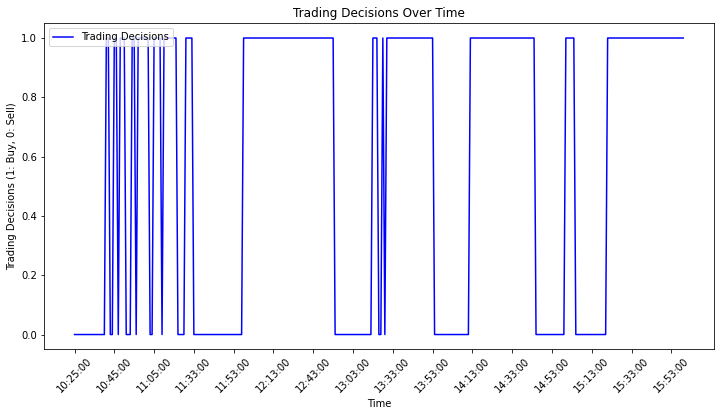

Latest Decision: Buy


In [101]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

# Assuming 'data' is your DataFrame with timestamp as the index
timestamps = data.index

# Convert timestamps to time (hh:mm:ss) strings
time_of_day = [timestamp.strftime('%H:%M:%S') for timestamp in timestamps]
time_of_day = time_of_day[-len(trading_decisions):]

# Create an array of indices for x-axis labels
x_indices = np.arange(0, len(time_of_day), step=20)  # You can adjust the step as needed

# Create an array of x-axis labels based on the selected indices
x_labels = [time_of_day[i] for i in x_indices]

# Plot the trading decisions
plt.figure(figsize=(12, 6))
plt.plot(time_of_day, trading_decisions, label='Trading Decisions', color='b')
plt.xlabel('Time')
plt.ylabel('Trading Decisions (1: Buy, 0: Sell)')
plt.title('Trading Decisions Over Time')
plt.xticks(x_indices, x_labels, rotation=45)  # Set the x-axis labels
plt.legend(loc='upper left')
plt.show()

# Print the latest or final decision
latest_decision = trading_decisions[-1]
print("Latest Decision: Buy" if latest_decision == 1 else "Latest Decision: Do Not Buy")


In [93]:
import numpy as np
import pandas as pd
import yfinance as yf  # Import yfinance library
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define a list of stock tickers
tickers = ["TSLA", "AAPL", "GOOGL", "COST", "GME", "NFLX", "GLD", "NVDA", "PLTR" ]  # Add more tickers as needed

# Create an empty dictionary to hold the data for each stock
stock_data = {}

for ticker in tickers:
    data = yf.download(ticker, period="ytd", interval="1d")
    stock_data[ticker] = data

# Calculate Ichimoku components, additional indicators, and normalization for each stock
tenkan_period = 9
kijun_period = 26
senkou_period = 52
ma_period = 20
rsi_period = 14

def normalize_and_fill(column):
    min_val = column.min()
    max_val = column.max()
    column = ((column - min_val) / (max_val - min_val)) * 255
    return column.fillna(0).astype(int)

for ticker in tickers:
    stock_data[ticker]['Tenkan'] = stock_data[ticker]['High'].rolling(window=tenkan_period).max()
    stock_data[ticker]['Kijun'] = stock_data[ticker]['High'].rolling(window=kijun_period).max()
    
    stock_data[ticker]['Senkou A'] = ((stock_data[ticker]['Tenkan'] + stock_data[ticker]['Kijun']) / 2).shift(senkou_period)
    stock_data[ticker]['Senkou B'] = (stock_data[ticker]['High'].rolling(window=senkou_period).max() + stock_data[ticker]['Low'].rolling(window=senkou_period).min()) / 2
    
    stock_data[ticker]['MA'] = stock_data[ticker]['Close'].rolling(ma_period).mean()

    delta = stock_data[ticker]['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    average_gain = gain.rolling(window=rsi_period).mean()
    average_loss = loss.rolling(window=rsi_period).mean()
    rs = average_gain / average_loss
    stock_data[ticker]['RSI'] = 100 - (100 / (1 + rs))

    # Normalize and fill non-finite values for each indicator
    stock_data[ticker]['Tenkan'] = normalize_and_fill(stock_data[ticker]['Tenkan'])
    stock_data[ticker]['Kijun'] = normalize_and_fill(stock_data[ticker]['Kijun'])
    stock_data[ticker]['Senkou A'] = normalize_and_fill(stock_data[ticker]['Senkou A'])
    stock_data[ticker]['Senkou B'] = normalize_and_fill(stock_data[ticker]['Senkou B'])
    stock_data[ticker]['MA'] = normalize_and_fill(stock_data[ticker]['MA'])
    stock_data[ticker]['RSI'] = normalize_and_fill(stock_data[ticker]['RSI'])

# Construct image samples
X = []
y = []
input_window = 50
output_window = 5

for ticker in tickers:
    for i in range(input_window, len(stock_data[ticker]) - output_window):
        x_i = np.dstack([
            stock_data[ticker]['Tenkan'].values[i - input_window:i],
            stock_data[ticker]['Kijun'].values[i - input_window:i],
            stock_data[ticker]['Senkou A'].values[i - input_window:i],
            stock_data[ticker]['Senkou B'].values[i - input_window:i],
            stock_data[ticker]['MA'].values[i - input_window:i],
            stock_data[ticker]['RSI'].values[i - input_window:i]
        ])
        
        X.append(x_i)
        y.append(stock_data[ticker]['Close'].values[i + output_window] > stock_data[ticker]['Close'].values[i])
# Print the number of images
print(f"Number of images input into the model: {len(X)}")
X = np.array(X)
X = X.reshape(-1, input_window, 6, 1)
y = np.array(y)

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Define the model
input_shape = (input_window, 6, 1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile and train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Number of images input into the model: 1314
Epoch 1/50
33/33 [==============================] - 0s 2ms/step - loss: 2.7569 - accuracy: 0.5480
Epoch 2/50
33/33 [==============================] - 0s 2ms/step - loss: 1.5493 - accuracy: 0.5966
Epoch 3/50
33/33 [==============================] - 0s 2ms/step - loss: 1.1358 - accuracy: 0.6175
Epoch 4/50
33/33 [=======================

In [ ]:
# 3 stocks 339 images, Mean Squared Error on Validation Set: [1.0082502365112305, 0.720588207244873]
# 6 678; Mean Squared Error on Validation Set: [0.9736000299453735, 0.7573529481887817]
# 9 1314, Mean Squared Error on Validation Set: [1.0778952836990356, 0.6577946543693542]

[*********************100%%**********************]  1 of 1 completed
NAs count before filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        8
Kijun        25
Senkou A     77
Senkou B     51
MA           19
RSI          13
dtype: int64
NAs count after filling:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Tenkan       0
Kijun        0
Senkou A     0
Senkou B     0
MA           0
RSI          0
dtype: int64


C:\Users\beaud\AppData\Local\Temp\ipykernel_15336\3231407820.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Tenkan'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_15336\3231407820.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Kijun'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_15336\3231407820.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Senkou A'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_15336\3231407820.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Senkou B'].fillna(method=

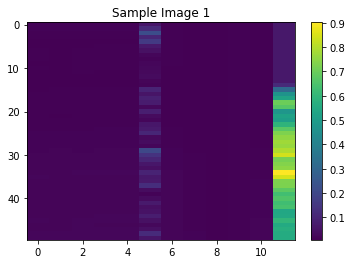

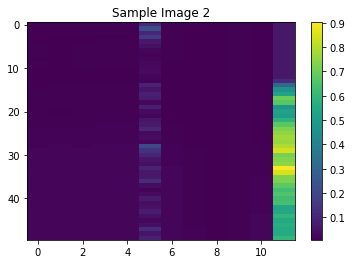

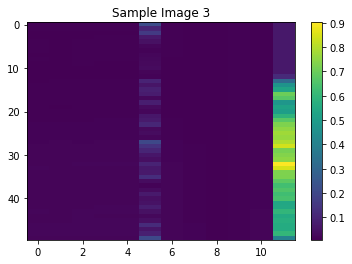

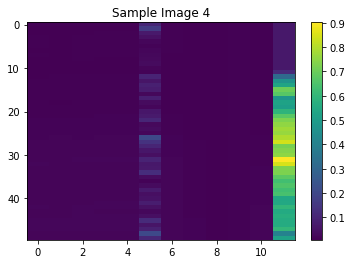

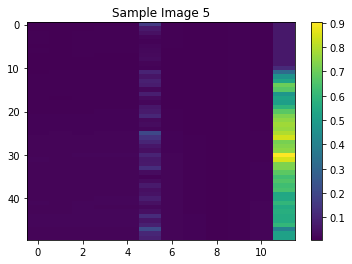

Epoch 1/200
82/82 [==============================] - 1s 4ms/step - loss: 4184.0381
Epoch 2/200
82/82 [==============================] - 0s 4ms/step - loss: 882.3953
Epoch 3/200
82/82 [==============================] - 0s 4ms/step - loss: 688.8009
Epoch 4/200
82/82 [==============================] - 0s 4ms/step - loss: 696.1069
Epoch 5/200
82/82 [==============================] - 0s 4ms/step - loss: 754.2535
Epoch 6/200
82/82 [==============================] - 0s 4ms/step - loss: 545.7926
Epoch 7/200
82/82 [==============================] - 0s 4ms/step - loss: 468.2009
Epoch 8/200
82/82 [==============================] - 0s 4ms/step - loss: 479.9636
Epoch 9/200
82/82 [==============================] - 0s 4ms/step - loss: 404.8607
Epoch 10/200
82/82 [==============================] - 0s 4ms/step - loss: 364.7473
Epoch 11/200
82/82 [==============================] - 0s 4ms/step - loss: 388.5142
Epoch 12/200
82/82 [==============================] - 0s 4ms/step - loss: 524.4863
Epoch 13/200

Epoch 100/200
82/82 [==============================] - 0s 4ms/step - loss: 95.1297
Epoch 101/200
82/82 [==============================] - 0s 4ms/step - loss: 95.0664
Epoch 102/200
82/82 [==============================] - 0s 4ms/step - loss: 103.8049
Epoch 103/200
82/82 [==============================] - 0s 4ms/step - loss: 99.7426
Epoch 104/200
82/82 [==============================] - 0s 4ms/step - loss: 117.9957
Epoch 105/200
82/82 [==============================] - 0s 4ms/step - loss: 87.2296
Epoch 106/200
82/82 [==============================] - 0s 4ms/step - loss: 109.4369
Epoch 107/200
82/82 [==============================] - 0s 4ms/step - loss: 89.6991
Epoch 108/200
82/82 [==============================] - 0s 4ms/step - loss: 70.7503
Epoch 109/200
82/82 [==============================] - 0s 4ms/step - loss: 79.3006
Epoch 110/200
82/82 [==============================] - 0s 4ms/step - loss: 69.8676
Epoch 111/200
82/82 [==============================] - 0s 4ms/step - loss: 63.2642
E

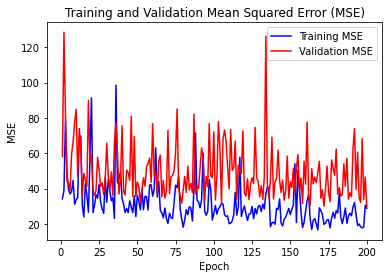

In [95]:
#train model for closing prices
import numpy as np
import pandas as pd
import yfinance as yf  # Import yfinance library
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Download stock data
ticker = "TSLA" 
data = yf.download(ticker, period="80mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max() 
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)  
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate additional indicators
ma_period = 20
data['MA'] = data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 14
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Check the NAs before filling
na_count_before = data.isna().sum()
print("NAs count before filling:")
print(na_count_before)

# Backward-fill NAs
data['Tenkan'].fillna(method='bfill', inplace=True)
data['Kijun'].fillna(method='bfill', inplace=True)
data['Senkou A'].fillna(method='bfill', inplace=True)
data['Senkou B'].fillna(method='bfill', inplace=True)
data['MA'].fillna(method='bfill', inplace=True)
data['RSI'].fillna(method='bfill', inplace=True)

# Check the NAs count after filling
na_count_after = data.isna().sum()
print("NAs count after filling:")
print(na_count_after)

# Drop rows with remaining NAs
data.dropna(inplace=True)

# Construct input samples
X = []
y = []
input_window = 50
output_window = 1  # Predict the next closing price

for i in range(input_window, len(data) - output_window):
    x_i = np.dstack([
        data['Tenkan'].values[i - input_window:i],
        data['Kijun'].values[i - input_window:i],
        data['Senkou A'].values[i - input_window:i],
        data['Senkou B'].values[i - input_window:i],
        data['MA'].values[i - input_window:i],
        data['RSI'].values[i - input_window:i]
    ])

    X.append(x_i)
    y.append(data['Close'].values[i + output_window])  # Use the next closing price

X = np.array(X)
X = X.reshape(-1, input_window, 6, 1)

# Convert y to a NumPy array
y = np.array(y)

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) 

# Define model for regression
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))  # Change activation function to linear for regression

# Compile and train
model.compile(loss='mse', optimizer='adam') # Use mean squared error as loss for regression
model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=1)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)

import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(X_val, y_val), 
                    verbose=0)


# Access the MSE values from the history
train_mse = history.history['loss']
val_mse = history.history['val_loss']

# Plot both training and validation MSE
plt.plot(range(1, len(train_mse) + 1), train_mse, label='Training MSE', color='blue')
plt.plot(range(1, len(val_mse) + 1), val_mse, label='Validation MSE', color='red')
plt.title('Training and Validation Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed
4/4 [==============================] - 0s 3ms/step
Latest Predicted Closing Price: 239.67043


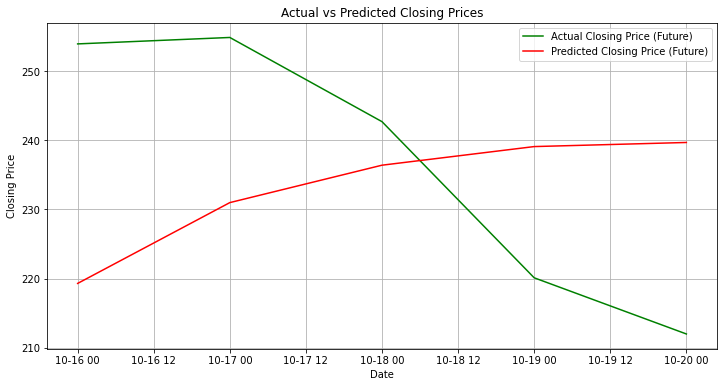

In [79]:
import numpy as np
import yfinance as yf
import pandas as pd

# Download historical data for the stock (e.g., TSLA)
ticker = "TSLA"
data = yf.download(ticker, period="8mo", interval="1d")

# Calculate Ichimoku components, moving average (MA), and RSI as you did before
tenkan_period = 9
kijun_period = 26
senkou_period = 52
ma_period = 20
rsi_period = 14

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max()
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

delta = data['Close'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

# Convert gain and loss to DataFrames to use rolling mean
gain = pd.Series(gain)
loss = pd.Series(loss)

average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Average (MA) for the data
data['MA'] = data['Close'].rolling(ma_period).mean()

# Define a function to normalize and fill non-finite values
def normalize_and_fill(column):
    min_val = column.min()
    max_val = column.max()
    column = ((column - min_val) / (max_val - min_val)) * 255
    return column.fillna(0).astype(int)

data['Tenkan'] = normalize_and_fill(data['Tenkan'])
data['Kijun'] = normalize_and_fill(data['Kijun'])
data['Senkou A'] = normalize_and_fill(data['Senkou A'])
data['Senkou B'] = normalize_and_fill(data['Senkou B'])
data['MA'] = normalize_and_fill(data['MA'])
data['RSI'] = normalize_and_fill(data['RSI'])

# Extract and preprocess data for predictions
input_window = 50  # Should match your training window size
output_window = 5   # The number of days into the future to predict

X = []
y = []

for i in range(input_window, len(data) - output_window):
    x_i = np.dstack([
        data['Tenkan'].values[i - input_window:i],
        data['Kijun'].values[i - input_window:i],
        data['Senkou A'].values[i - input_window:i],
        data['Senkou B'].values[i - input_window:i],
        data['MA'].values[i - input_window:i],
        data['RSI'].values[i - input_window:i]
    ])

    X.append(x_i)
    y.append(data['Close'].values[i + output_window])

# Make sure X is a 4D numpy array with the shape (number of samples, input_window, number of features, 1)
X = np.array(X)
X = X.reshape(-1, input_window, 6, 1)

# Convert y to a NumPy array
y = np.array(y)

# Make predictions using your trained model (ensure you load the model before this step)
predicted_closing_prices = model.predict(X)  # X is your input data

# Reverse the normalization process if needed when interpreting predictions

# Print the latest or final predicted closing price
latest_predicted_price = predicted_closing_prices[-1][0]
print("Latest Predicted Closing Price:", latest_predicted_price)
import matplotlib.pyplot as plt

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[-output_window:], data['Close'][-output_window:], label='Actual Closing Price (Future)', color='green')
plt.plot(data.index[-output_window:], predicted_closing_prices[-output_window:], label='Predicted Closing Price (Future)', color='red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.grid()


plt.show()



[*********************100%%**********************]  1 of 1 completed
NAs count before filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        8
Kijun        25
Senkou A     77
Senkou B     51
MA           19
RSI          13
dtype: int64
NAs count after filling:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Tenkan       0
Kijun        0
Senkou A     0
Senkou B     0
MA           0
RSI          0
dtype: int64
Number of samples before generating images: 1679


C:\Users\beaud\AppData\Local\Temp\ipykernel_15336\4038512539.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Tenkan'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_15336\4038512539.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Kijun'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_15336\4038512539.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Senkou A'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_15336\4038512539.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Senkou B'].fillna(method=

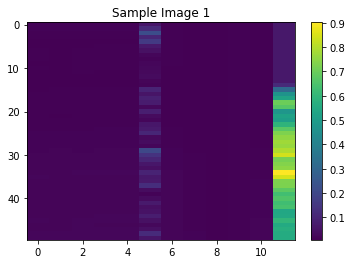

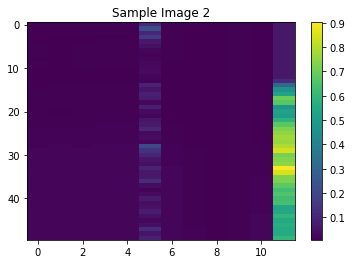

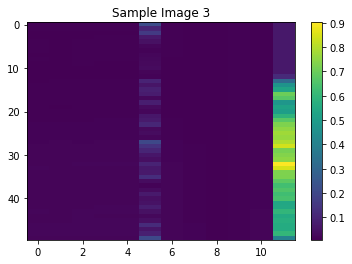

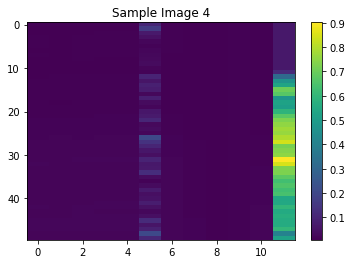

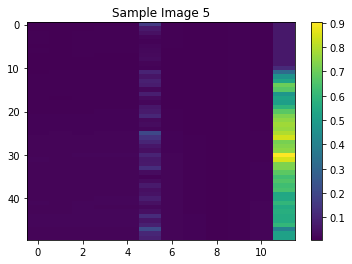

Number of samples after generating images: 1629
Look at X: [[0.01574875 0.01570612 0.01642177 0.01648416 0.01648416 0.06301565
  0.01365819 0.0081418  0.00872632 0.01315322 0.01012425 0.06617486]
 [0.01655998 0.01604605 0.01618311 0.01583431 0.01583431 0.11520909
  0.01365819 0.0081418  0.00872632 0.01315322 0.01012425 0.06617486]
 [0.01383754 0.01293036 0.01329889 0.01289992 0.01289992 0.219657
  0.01365819 0.0081418  0.00872632 0.01315322 0.01012425 0.06617486]
 [0.01194468 0.01186748 0.01239165 0.01306908 0.01306908 0.10531738
  0.01365819 0.0081418  0.00872632 0.01315322 0.01012425 0.06617486]
 [0.01119522 0.01022755 0.0110054  0.01126524 0.01126524 0.16108668
  0.01365819 0.0081418  0.00872632 0.01315322 0.01012425 0.06617486]
 [0.01053088 0.01066531 0.01132531 0.01189499 0.01189499 0.0698215
  0.01365819 0.0081418  0.00872632 0.01315322 0.01012425 0.06617486]
 [0.0121984  0.0113037  0.01220716 0.01190002 0.01190002 0.04831203
  0.01365819 0.0081418  0.00872632 0.01315322 0.010124

82/82 [==============================] - 1s 8ms/step - loss: 19.1561
Epoch 116/200
82/82 [==============================] - 1s 8ms/step - loss: 32.2992
Epoch 117/200
82/82 [==============================] - 1s 8ms/step - loss: 15.6013
Epoch 118/200
82/82 [==============================] - 1s 8ms/step - loss: 22.8200
Epoch 119/200
82/82 [==============================] - 1s 8ms/step - loss: 14.5829
Epoch 120/200
82/82 [==============================] - 1s 8ms/step - loss: 15.8663
Epoch 121/200
82/82 [==============================] - 1s 8ms/step - loss: 12.4902
Epoch 122/200
82/82 [==============================] - 1s 8ms/step - loss: 14.5381
Epoch 123/200
82/82 [==============================] - 1s 8ms/step - loss: 13.7017
Epoch 124/200
82/82 [==============================] - 1s 8ms/step - loss: 13.8443
Epoch 125/200
82/82 [==============================] - 1s 8ms/step - loss: 11.2679
Epoch 126/200
82/82 [==============================] - 1s 8ms/step - loss: 14.0023
Epoch 127/200
82/8

In [111]:
#train with images instead: import numpy as np
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Download stock data
ticker = "TSLA"
data = yf.download(ticker, period="80mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max()
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate additional indicators
ma_period = 20
data['MA'] = data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 14
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Check the NAs before filling
na_count_before = data.isna().sum()
print("NAs count before filling:")
print(na_count_before)

# Backward-fill NAs
data['Tenkan'].fillna(method='bfill', inplace=True)
data['Kijun'].fillna(method='bfill', inplace=True)
data['Senkou A'].fillna(method='bfill', inplace=True)
data['Senkou B'].fillna(method='bfill', inplace=True)
data['MA'].fillna(method='bfill', inplace=True)
data['RSI'].fillna(method='bfill', inplace=True)

# Check the NAs count after filling
na_count_after = data.isna().sum()
print("NAs count after filling:")
print(na_count_after)

print("Number of samples before generating images:", len(data))

# Create images from the data
image_width = 50  # Corresponding to your time window
image_height = 12  # Number of technical indicators

# Create an empty array to store the images
images = []

# Normalize your data for better visualization (scaling to the [0, 1] range)
normalized_data = (data - data.min()) / (data.max() - data.min())

# Loop through the data and create images
for i in range(image_width, len(data)):
    image = normalized_data.iloc[i - image_width:i].values
    images.append(image)

# Convert the images list to a NumPy array
X = np.array(images)

# Visualize some of the images (optional)
num_sample_images = 5  # Change this to see more or fewer sample images

for i in range(num_sample_images):
    plt.figure()
    plt.imshow(X[i], cmap='viridis', aspect='auto')
    plt.title(f"Sample Image {i+1}")
    plt.colorbar()
    plt.show()
    
# Define the target variable
y = data['Close'].shift(-1).dropna().values
print("Number of samples after generating images:", len(X))
print("Look at X:",X[0])

# Ensure X and y have the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


# Define model for regression
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_width, image_height, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile and train
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=1)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)

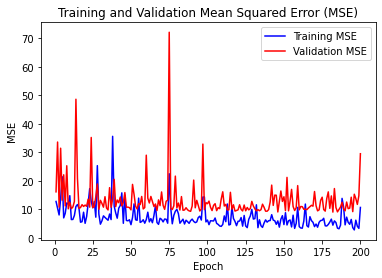

In [112]:
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(X_val, y_val), 
                    verbose=0)


# Access the MSE values from the history
train_mse = history.history['loss']
val_mse = history.history['val_loss']

# Plot both training and validation MSE
plt.plot(range(1, len(train_mse) + 1), train_mse, label='Training MSE', color='blue')
plt.plot(range(1, len(val_mse) + 1), val_mse, label='Validation MSE', color='red')
plt.title('Training and Validation Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed
51/51 [==============================] - 0s 3ms/step


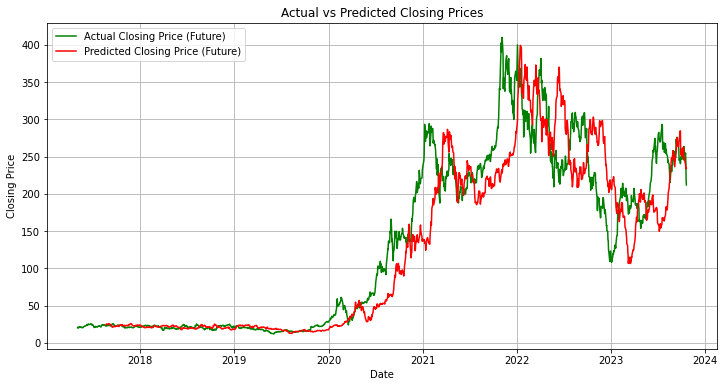

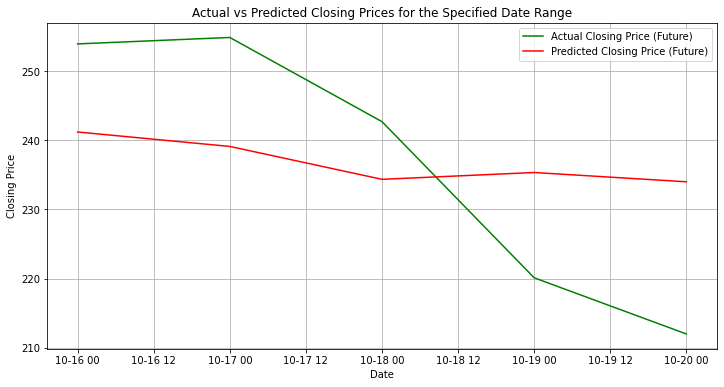

Data for the Last Plot:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-10-16  250.050003  255.399994  248.479996  253.919998  253.919998   
2023-10-17  250.100006  257.179993  247.080002  254.850006  254.850006   
2023-10-18  252.699997  254.630005  242.080002  242.679993  242.679993   
2023-10-19  225.949997  230.610001  216.779999  220.110001  220.110001   
2023-10-20  217.009995  218.860001  210.419998  211.990005  211.990005   

               Volume      Tenkan       Kijun    Senkou A    Senkou B  \
Date                                                                    
2023-10-16   88917200  268.940002  278.980011  286.095001  245.670006   
2023-10-17   93562900  268.940002  278.980011  286.095001  245.670006   
2023-10-18  125147800  268.940002  278.980011  286.095001  245.670006   
2023-10-19  170772700  268.940002  278.980011  284.210007  245.670006   
2023-10-20  1377340

In [133]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Download historical data for the stock (e.g., TSLA)
ticker = "TSLA"
data = yf.download(ticker, period="80mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max()
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate additional indicators
ma_period = 20
data['MA'] = data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 14
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Define the date range for the current week
current_date = datetime.now()
start_of_week = current_date - timedelta(days=current_date.weekday())
end_of_week = start_of_week + timedelta(days=6)

# Filter data for the current week
data_current_week = data[(data.index >= start_of_week) & (data.index <= end_of_week)]

# Create images from the data
image_width = 50  # Should match your training window size
image_height = 12  # Number of technical indicators

# Create an empty array to store the images
images = []

# Normalize your data for better visualization (scaling to the [0, 1] range)
normalized_data = (data - data.min()) / (data.max() - data.min())

# Loop through the data and create images
for i in range(image_width, len(data)):
    image = normalized_data.iloc[i - image_width:i].values
    images.append(image)

# Convert the images list to a NumPy array
X = np.array(images)

# Make predictions using your trained model
predicted_closing_prices = model.predict(X)  # X is your input data

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(predicted_closing_prices):], data['Close'].tail(len(predicted_closing_prices)), label='Actual Closing Price (Future)', color='green')
plt.plot(data.index[-len(predicted_closing_prices):], predicted_closing_prices, label='Predicted Closing Price (Future)', color='red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.grid()

# Filter data for the specific date range
start_date = '2023-10-16'
end_date = '2023-10-20'
data_filtered = data[(data.index >= start_date) & (data.index <= end_date)]

# Trim predicted_closing_prices to match the length of data_filtered
predicted_closing_prices = predicted_closing_prices[-len(data_filtered):]

# Create a plot for the filtered data
plt.figure(figsize=(12, 6))
plt.plot(data_filtered.index.to_numpy(), data_filtered['Close'], label='Actual Closing Price (Future)', color='green')
plt.plot(data_filtered.index.to_numpy(), predicted_closing_prices.flatten(), label='Predicted Closing Price (Future)', color='red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices for the Specified Date Range')
plt.legend()
plt.grid()
plt.show()

# Print the data for the last plot
print("Data for the Last Plot:")
print(data_filtered)


In [149]:
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define the date range for the next week
start_of_next_week = datetime(2023, 10, 23)
end_of_next_week = datetime(2023, 10, 27)

# Define the number of days to extrapolate
num_days_to_extrapolate = (end_of_next_week - data.index[-1]).days

# Define the image width (you should set this according to your model)
image_width = 7

# Create extended input data for the next week
last_data_point = data.iloc[-1].copy()
input_data_next_week = []

for day in range(num_days_to_extrapolate + 1):
    current_date = data.index[-1] + timedelta(days=day)
    last_data_point.name = current_date
    input_data_next_week.append(last_data_point)

# Convert input data for the next week to a DataFrame
input_data_next_week = pd.DataFrame(input_data_next_week)

# Normalize the input data for the next week
normalized_input_next_week = (input_data_next_week - data.min()) / (data.max() - data.min())

# Make predictions for each day in the next week
predicted_closing_prices_next_week = []

# Initialize with the last data points in the available data
current_data = normalized_input_next_week.values[-image_width:]

for _ in range(num_days_to_extrapolate + 1):
    # Reshape to match the model's input shape
    current_data_reshaped = current_data.reshape(1, image_width, 12, 1)
    
    # Predict the next data point
    prediction = model.predict(current_data_reshaped)
    
    # Append the prediction to the results
    predicted_closing_prices_next_week.append(prediction[0][0])
    
    # Update current_data by removing the first data point and appending the prediction
    current_data = np.vstack((current_data[1:], prediction))

# Now you have predictions for each day in the next week

# Plot actual and predicted closing prices for both the current and next week
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Actual Closing Price', color='green')
plt.plot(next_week_dates, predicted_closing_prices_next_week, label='Predicted Closing Price (Next Week)', color='blue')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices for Next Week')
plt.legend()
plt.grid()
plt.show()

ValueError: in user code:

    File "C:\Users\beaud\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\beaud\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\beaud\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\beaud\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\beaud\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\beaud\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_108" is incompatible with the layer: expected shape=(None, 50, 12, 1), found shape=(None, 7, 12, 1)
